# Symbolic Regression

## Imports

In [1]:
import numpy as np
import random
from copy import deepcopy
import tqdm
import matplotlib.pyplot as plt
np.seterr(all='ignore')  # ignore all numpy warnings

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Operators

In [2]:
# Define the set of operators that can be used in the GP algorithm.
OPERATORS = [
    {"func_name": "add", "func": np.add, "arity": 2, "format_str": "({} + {})"},
    {"func_name": "subtract", "func": np.subtract, "arity": 2, "format_str": "({} - {})"},
    {"func_name": "multiply", "func": np.multiply, "arity": 2, "format_str": "({} * {})"},
    {"func_name": "divide", "func": np.divide, "arity": 2, "format_str": "({} / {})"},
    {"func_name": "power", "func": np.power, "arity": 2, "format_str": "({} ** {})"},
    {"func_name": "sqrt", "func": np.sqrt, "arity": 1, "format_str": "sqrt({})"},
    {"func_name": "log", "func": np.log, "arity": 1, "format_str": "log({})"},
    {"func_name": "sin", "func": np.sin, "arity": 1, "format_str": "sin({})"},
    {"func_name": "cos", "func": np.cos, "arity": 1, "format_str": "cos({})"},
    {"func_name": "arctan", "func": np.arctan, "arity": 1, "format_str": "arctan({})"},
    {"func_name": "sinh", "func": np.sinh, "arity": 1, "format_str": "sinh({})"},
    {"func_name": "cosh", "func": np.cosh, "arity": 1, "format_str": "cosh({})"},
    {"func_name": "tanh", "func": np.tanh, "arity": 1, "format_str": "tanh({})"},
    {"func_name": "exp", "func": np.exp, "arity": 1, "format_str": "exp({})"},  
    {"func_name": "abs", "func": np.abs, "arity": 1, "format_str": "abs({})"}
]

## Initial Population generation

In [147]:
def generate_grow(max_depth, features):
    """
    function that generates a random tree as candidate .
    """
    #if it is first node or random number is greater than 0.5, then return either a variable or a constant
    if max_depth == 0 or random.random() < 0.5:
        if random.random() < 0.9:
            return {"type": "x", "name": np.random.choice(range(np.array(features).shape[-1]))}  # Variable
        else:
            return {"type": "constant", "value": random.choice([x for x in range(-10, 11) if x != 0])}  # Costant
    operator = random.choice(OPERATORS)
    children = [generate_grow(max_depth - 1, features) for _ in range(operator["arity"])]
    return {"type": "op", "operator": operator, "children": children}

def generate_full(max_depth, features):

    if max_depth == 0:
        if random.random() < 0.9:
            return {"type": "x", "name": np.random.choice(range(np.array(features).shape[-1]))}
        else:
            return {"type": "constant", "value": random.choice([x for x in range(-10, 11) if x != 0])}
    operator = random.choice(OPERATORS)
    children = [generate_full(max_depth - 1, features) for _ in range(operator["arity"])]
    return {"type": "op", "operator": operator, "children": children}

def generate_candidate_half_half(max_depth, features):
    if random.random() < 0.5:
        return generate_grow(max_depth, features)
    else:
        return generate_full(max_depth, features)

## Mean Square Error (MSE)

In [5]:
def evaluate_function(node, data):
    if node["type"] == "x":
        return data.T[node["name"]]
    if node["type"] == "constant":
        return np.full(data.shape[0], node["value"])
    # Evaluate children
    children_values = [evaluate_function(child, data) for child in node["children"]]
    if any(child is None for child in children_values):
        return None  # discard invalid functions

    try:
        result = node["operator"]["func"](*children_values)
        if np.any(np.isinf(result)) or np.any(np.isnan(result)):
            return None  # discard invalid functions
        result = np.clip(result, -1e10, 1e10)  # Limit the output range
        return result
    except (FloatingPointError, ZeroDivisionError, ValueError):
        return None  # discard invalid functions

def calculate_mse(function, data, target):
    """
    Calculates the fitness of a function. If the function is valid, it computes the mean squared error (MSE).
    If the function is invalid (None, NaN, Inf), it will return a high value to exclude it from the evolutionary process.
    """
    result = evaluate_function(function, data)
    if result is None:
        return float("inf")  # Penalize invalid functions
    try:
        # calculate the mean squared error (MSE) as a measure of fitness
        error = np.mean((result - target) ** 2)
        return error
    except ValueError:  # If there is an error during the calculation of the MSE, penalize the function
        return float("inf")

## Utilities

In [97]:
# Load the dataset
def load_dataset(problem_n:int):
    data_path = f"/kaggle/input/homework-3/problem_{problem_n}.npz"
    data = np.load(data_path)
    features = data['x'].T
    target = data['y']
    return features, target

def get_individual_representation(node):
    if node["type"] == "x":
        return node["name"]
    if node["type"] == "constant":
        return f"{node['value']:.4f}"
    children = [get_individual_representation(child) for child in node["children"]]
    return node["operator"]["format_str"].format(*children)

def is_valid(function):
    # check if there is at least one variable node in tree
    if function['type'] == 'x':
        return True
    elif function['type'] == 'op':
        for child in function['children']:
            return is_valid(child)
    return False

## Selection Method

In [7]:
def tournament_selection(population, features, target, size):
    selected = np.random.choice(population, size)
    scores = [calculate_mse(p,features,target) for p in selected]
    return selected[np.argmin(scores)]

## Crossover

### Crossover Helper Functions

In [8]:
def get_nodes(tree):
    # function that retrieves all nodes of a tree
    n = []
    if "children" in tree:
        for children in tree['children']:
            n.extend(get_nodes(children))
    n.append(tree)

    return n
    
def get_leaf_nodes(node):
    """
    Function that retrieves all leaf nodes given a parent node.
    """
    # iif the node has no children, it's  a leaf
    if "children" not in node or not node["children"]:
        return [node]

    # otherwise, recursively explore the children to find the leaf nodes
    leaf_nodes = []
    for child in node["children"]:
        leaf_nodes.extend(get_leaf_nodes(child))

    return leaf_nodes

def replace_leaf(node, old_leaf, new_leaf):
    """
    Function that recursively replaces a leaf in a tree.
    """
    # if the current node is the old leaf, replace it with the new leaf
    if node == old_leaf:
        return deepcopy(new_leaf)
    # If the current node has children, explore recursively.
    if "children" in node:
        node["children"] = [replace_leaf(child, old_leaf, new_leaf) for child in node["children"]]

    return node
    
def get_operator_nodes(node):
    """
    Returns all operator nodes (non-leaf) of a tree.
    """
    nodes = []
    if node.get("type") == "op":
        nodes.append(node)
    if "children" in node:
        for child in node["children"]:
            nodes.extend(get_operator_nodes(child))
    return nodes

def get_parent_node(node, target):
    """
    Function that retrieves the parent of a target node.
    """

    if "children" not in node or not node["children"]:
        return None

    for child in node["children"]:
        if child is target:
            return node
        result = get_parent_node(child, target)
        if result:
            return result

    return None

def get_heigth_subtree(node):
    """
    Function that calculates the heigth of a subtree from the leaves towards the given node.
    """

    if "children" not in node or not node["children"]:
        # If the node has no children, it is a leaf and has height 0
        return 0
    return 1 + max(get_heigth_subtree(child) for child in node["children"])

def select_similar_height_node(node, target_height):
    """
    Function that returns a node in a tree with the closest heigth to the target one .
    Selects a node in a tree with a height similar to the target_height.
    """

    all_nodes = get_nodes(node)
    best_match = None
    min_diff = float("inf")
    for n in all_nodes:
        height = get_heigth_subtree(n)
        diff = abs(height - target_height)
        if diff < min_diff:
            min_diff = diff
            best_match = n
    return best_match

### Crossover functions

In [9]:
def crossover_random_height(parent_1, parent_2):
    # function to perform crossover between two trees of different height , swapping subtrees with a random height
    new_parent_1 = deepcopy(parent_1)
    new_parent_2 = deepcopy(parent_2)

    # Verify that both parents are operator nodes with valid children
    if new_parent_1["type"] != "op" or new_parent_2["type"] != "op":
        return new_parent_1  # No crossover possible, return the first parent
    # Verify that both parents have children
    if len(new_parent_1["children"]) == 0 or len(new_parent_2["children"]) == 0:
        return new_parent_1  # No crossover possible, return the first parent

    # 90% of swapping non-leaf nodes (subtrees)
    if random.random() < 0.9:

        if len(new_parent_1["children"]) != new_parent_1["operator"]["arity"] or len(new_parent_2["children"]) != new_parent_2["operator"]["arity"]:
            return new_parent_1  # No crossover possible, return the first parent
        # Select a random crossover point in parent_1 and parent_2
        swapping_point_1 = random.randint(0, len(new_parent_1["children"]) - 1)
        swapping_point_2 = random.randint(0, len(new_parent_2["children"]) - 1)

        # Swap the subtrees
        new_parent_1["children"][swapping_point_1], new_parent_2["children"][swapping_point_2] = (
            deepcopy(new_parent_2["children"][swapping_point_2]),
            deepcopy(new_parent_1["children"][swapping_point_1]),
        )
    else:
        # 10% probability of swapping leaf nodes
        leaves_parent_1 = get_leaf_nodes(new_parent_1)
        leaves_parent_2 = get_leaf_nodes(new_parent_2)

        if not leaves_parent_1 or not leaves_parent_2:
            return new_parent_1  # No crossover possible if there are no leaves

        # Select a random leaf from each parent
        leaf_1 = random.choice(leaves_parent_1)
        leaf_2 = random.choice(leaves_parent_2)

        # Replace the leaf
        new_parent_1 = replace_leaf(new_parent_1, leaf_1, leaf_2)
        new_parent_2 = replace_leaf(new_parent_2, leaf_2, leaf_1)

    return new_parent_1, new_parent_2

def crossover_similar_height(p1,p2):
    # perform crossover with two random subtree with similar height
    offspring_1 = deepcopy(p1)
    offspring_2 = deepcopy(p2)
    
    # choose a random subtree from p1
    subtree_1 = random.choice(get_nodes(offspring_1))
    # Get the height of the subtree
    height1 = get_heigth_subtree(subtree_1)

    # select similar subtree from p2
    subtree_2 = select_similar_height_node(offspring_2, height1)

    offspring_1 = replace_leaf(offspring_1, subtree_1, subtree_2)
    offspring_2 = replace_leaf(offspring_2, subtree_2, subtree_1)

    return offspring_1, offspring_2
    
def crossover_fixed_height(parent_1, parent_2):
    # Perform a crossover between two trees, swapping subtrees with a fixed maximum height
    new_parent_1 = deepcopy(parent_1)
    new_parent_2 = deepcopy(parent_2)

    # Verify that both parents are operator nodes with valid children
    if new_parent_1["type"] != "op" or new_parent_2["type"] != "op":
        return new_parent_1  # No crossover possible, return the first parent
    if len(new_parent_1["children"]) == 0 or len(new_parent_2["children"]) == 0:
        return new_parent_1  # No crossover possible, return the first parent
    if random.random() < 0.9:
        # Selects a random swap point in parent_1 with a maximum height of 3
        operator_nodes_1 = [node for node in get_operator_nodes(new_parent_1)
                        if get_heigth_subtree(node) <= 2]
        operator_nodes_2 = [node for node in get_operator_nodes(new_parent_2)
                        if get_heigth_subtree(node) <= 2]

        if not operator_nodes_1 or not operator_nodes_2:
            return new_parent_1  # No valid swap point in parent_1

        # Select a random swap point in parent_1 and parent_2
        swapping_point_1 = random.choice(operator_nodes_1)
        swapping_point_2 = random.choice(operator_nodes_2)

        new_parent_1 = replace_leaf(new_parent_1, swapping_point_1, swapping_point_2)
        new_parent_2 = replace_leaf(new_parent_2, swapping_point_2, swapping_point_1)
    else:
        leaves_parent_1 = get_leaf_nodes(new_parent_1)
        leaves_parent_2 = get_leaf_nodes(new_parent_2)

        if not leaves_parent_1 or not leaves_parent_2:
            return new_parent_1  # No crossover possible if there are no leaves
        # Select a random leaf from each parent
        leaf_1 = random.choice(leaves_parent_1)
        leaf_2 = random.choice(leaves_parent_2)

        # Replace the leaf
        new_parent_1 = replace_leaf(new_parent_1, leaf_1, leaf_2)
        new_parent_2 = replace_leaf(new_parent_2, leaf_2, leaf_1)

    return new_parent_1, new_parent_2

## Mutation

### Mutation helper functions

In [10]:
def get_subtrees_with_height(node, parent=None, index=None, current_height=0):
        # Retrieves all subtrees (pointers to nodes, parents, indices, and heights).
        subtrees = []
        if node["type"] == "op":  # only consider operator nodes
            for i, child in enumerate(node["children"]):
                subtree_height = get_heigth_subtree(child)
                subtrees.append((node, i, subtree_height))  # Store the parent, index, and height
                subtrees.extend(get_subtrees_with_height(child, node, i, current_height + 1))
        return subtrees

def perform_erc_mutation(offspring):
# Perform the ERC mutation
    updated = False
    while not updated:
        updates = random.uniform(-1, 1)  # Generate a random value
        old_val = offspring['value']
        new_val = updates + old_val
        if new_val != 0:  # Ensure the value is not zero
            return {"type": "constant", "value": new_val}

### Mutation functions

In [11]:
def hoist_mutation(function):
    subtree = random.choice(get_nodes(function))
    return subtree

def mutate_erc(function, features):
    
    offspring = deepcopy(function)
    
    # if constant -> mutate value
    if offspring["type"] == "constant":
        return perform_erc_mutation(offspring)

    # If the current node is an operator, recursively mutate the children
    elif function["type"] == "op":
        child_idx = random.randint(0, len(function["children"]) - 1)
        function["children"][child_idx] = mutate_erc(function["children"][child_idx], features)

    return function

def swap_mutation(function):
 
    function = deepcopy(function)
    # Get all subtrees with their heights
    subtrees = get_subtrees_with_height(function)
    if len(subtrees) < 2:
        return function  # No mutation possible
    # Select a random subtree
    parent_1, idx1, height1 = random.choice(subtrees)

    subtrees_sorted_by_height_diff = sorted(
        subtrees,
        key=lambda x: abs(x[2] - height1)  # Sort by the absolute difference in height
    )

   # filter out subtrees that are too similar in height
    for parent_2, idx2, _ in subtrees_sorted_by_height_diff:
        if (parent_1, idx1) != (parent_2, idx2):  # Ensure the subtrees are different
            # Swap the subtrees
            parent_1["children"][idx1], parent_2["children"][idx2] = (
                deepcopy(parent_2["children"][idx2]),
                deepcopy(parent_1["children"][idx1]),
            )
            break

    return function

## Evolution 

In [148]:
def evolve_population(features, data, target, t_size):
    
    # Initialize the population with valid individuals only
    population = []
    while len(population) < POP_SIZE:
        candidate = generate_candidate_half_half(MAX_DEPTH, data)
        if evaluate_function(candidate, data) is not None:  # Ensure the function is valid
            population.append(candidate)

    best_MSE = np.inf
    history = []
    repetition = 0
    # Evolve the population
    for _ in tqdm.tqdm(range(MAX_GENERATIONS)):
        offspring_list = []
            
        # Generate new individuals for the population
        while len(offspring_list) < OFFSPRING_SIZE:
            
            parent_1 = tournament_selection(population, data, target, t_size)
            # sample parent 2 if crossover
            if random.random() > MUTATION_PROB:
                # Crossover
                parent_2 = tournament_selection(population, data, target, t_size)
                if random.random() < 0.7:
                    # choose between crossover_similar_height and crossover_random_height
                    if random.random() < 0.5:
                        offspring = crossover_random_height(parent_1, parent_2)
                    else:
                        offspring = crossover_similar_height(parent_1, parent_2)
                else:
                    # exploitation
                    offspring = crossover_fixed_height(parent_1, parent_2)
                
            else:
                # Mutation
                needle = random.random()
                if needle <= ERC_RATE:
                    offspring = mutate_erc(parent_1, features)
                elif needle > ERC_RATE and needle <= ERC_RATE + NEW_TREE_RATE:
                    offspring = generate_candidate_half_half(MAX_DEPTH, data)
                elif needle > ERC_RATE + NEW_TREE_RATE and needle <= ERC_RATE + NEW_TREE_RATE + HOIST_RATE:
                    offspring = hoist_mutation(parent_1)
                else:
                    assert needle > ERC_RATE + NEW_TREE_RATE + HOIST_RATE, "Error in choosing mutation method!"
                    offspring = swap_mutation(parent_1)
    
            # Validate the offspring
            if type(offspring) == tuple:
                for child in offspring:
                    if is_valid(child) and evaluate_function(child, data) is not None:
                        offspring_list.append(child)
            else:
                if is_valid(offspring) and evaluate_function(offspring, data) is not None:
                    offspring_list.append(offspring)
        
        # Combine old population with new offsprings
        population.extend(offspring_list)
        mse_scores = [calculate_mse(tree, data, target) for tree in population]
        
        # Sort the combined population by their MSE scores
        stack_pop = np.stack((population,mse_scores),axis=1)
        sorted_pop = np.array(sorted(stack_pop, key=lambda i: i[-1]))
        # save top individuals in population
        population = sorted_pop[:TOP_INDIVIDUAL,0].tolist()
        # add minory of individuals in bottom of population (usually it is not necessary)
        # population.extend(sorted_pop[-BOTTOM_INDIVIDUAL:,0].tolist())

        # update best function
        best_mse_gen = calculate_mse(population[0], data, target)
        if best_mse_gen < best_MSE:
            best_function = population[0]
            best_MSE = best_mse_gen
            
        history.append(best_MSE)

        # implement a counter to start from scratch if mse gets stuck
        if best_mse_gen == best_MSE:
            repetition += 1
        else:
            repetition = 0
            
        if repetition > 25:
            # initialize population from scratch
            best_function = deepcopy(population[0])
            population = []
            repetition = 0
            while len(population) < POP_SIZE:
                candidate = generate_candidate_half_half(MAX_DEPTH, data)
                if evaluate_function(candidate, data) is not None:  # Ensure the function is valid
                    population.append(candidate)
            population.append(best_function)
        
        if best_MSE < 1e-20:
            break
            
    plt.figure(figsize=(10,5))
    plt.plot(history)
    plt.show()
    return best_function, best_MSE

## Symbolic Regression

100%|██████████| 300/300 [03:30<00:00,  1.42it/s]


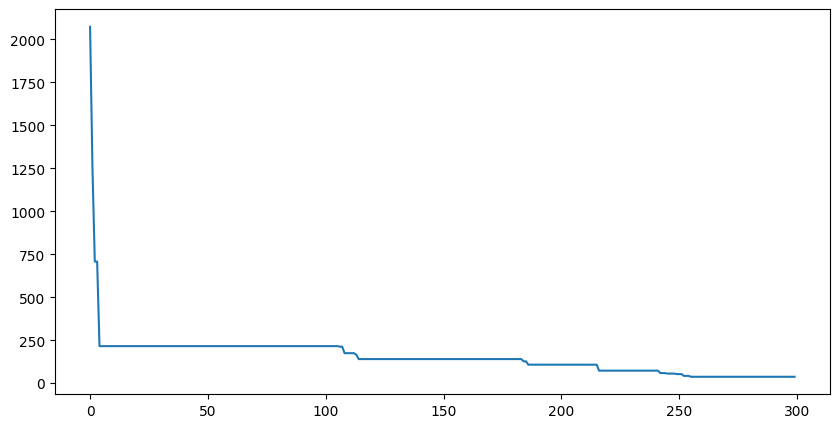

Best function: (((((((0 * 0) + tanh(6.5153)) - sinh(1)) + (((((0 * 0) + tanh(6.5153)) + tanh(6.5153)) + tanh(6.5153)) - sinh(1))) - 2) - 2) - 2)
 MSE: 3772.06


In [149]:
# Parameters defining the evolution of the GP algorithm.

# max depth of random initialized tree
MAX_DEPTH = 5
# population size
POP_SIZE = 500
# size of new generation
OFFSPRING_SIZE = 256
# portion of population to pass to next generation
TOP_INDIVIDUAL = 256 
# amount of worse part of population who survive to next generation
BOTTOM_INDIVIDUAL = 50
# number of generation to evolve
MAX_GENERATIONS = 300
# size of tournament to select parent
TOURNAMENT_SIZE = 5 
# probability of mutation to happen, probability of crossover = 1-P(mutation)
MUTATION_PROB = 0.05
# conditioned probability of ERC mutation
ERC_RATE = 0.2
# conditioned probability of initialize a new tree
NEW_TREE_RATE = 0.3
# conditioned probability of hoist mutation
HOIST_RATE = 0.3
assert ERC_RATE + NEW_TREE_RATE + HOIST_RATE < 1, 'Error in mutations rate!'
# number of sample of original dataset
SAMPLES = 1000

# Load the dataset
problem = 3
file_path = f"/kaggle/input/homework-3/problem_{problem}.npz"
features, target = load_dataset(problem)
features_name = [f"x{i}" for i in range(features.shape[-1])]

# sample dataset to speed up execution
if features.shape[0] > SAMPLES:
    idx = np.random.choice(features.shape[0], SAMPLES, replace=False)
    features = np.array(features[idx])
    target = np.array(target[idx])

# run algorithm
best_tree, best_MSE = evolve_population(features_name, features, target, TOURNAMENT_SIZE)
print(f"Best function: {get_individual_representation(best_tree)}\n MSE: {100*best_MSE:.2f}")